In [5]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
ratings = pd.read_pickle("./Data/small_random_selection_longform.pkl")

In [8]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()
n_users

37235

In [9]:
item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()
n_movies

29758

In [10]:
nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

In [13]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [14]:
len(X_train)

388607

In [15]:
l2_1 = keras.regularizers.l2(.1)
l2_01 = 'l2'
l2_001 = keras.regularizers.l2(.001)

In [16]:
HP_NUM_UNITS = [64]
HP_DROPOUT = [.3, .4, .5]
HP_LEARNING_RATE = [.01]
HP_REGULARIZER = [l2_1, l2_01]

In [19]:
def train_test_model(hparams):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    x = keras.layers.Dense(hparams['HP_NUM_UNITS'], 
                           activation='relu', 
                           kernel_regularizer=hparams['HP_REGULARIZER'])(conc_layer)
    dropout = x = keras.layers.Dropout(rate=hparams['HP_DROPOUT'], seed=42)(x)
    x_out = x = keras.layers.Dense(1, 
                                   activation='relu',
                                  kernel_regularizer=hparams['HP_REGULARIZER'])(x)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=hparams['HP_LEARNING_RATE'])
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())
    
    hist = model.fit([X_train.movie, X_train.user], 
                 X_train.rating_score,  
                 batch_size=len(X_train), epochs=20, validation_split=.2)

#     print(hist.history['val_mean_squared_error'])
    return hist

In [20]:
run_history = {}

session_num = 0

for num_units in HP_NUM_UNITS:
    for dropout_rate in HP_DROPOUT:
        for learning_rate in HP_LEARNING_RATE:
            for regularization in HP_REGULARIZER:
                hparams = {
                'HP_NUM_UNITS': num_units,
                'HP_DROPOUT': dropout_rate,
                'HP_LEARNING_RATE': learning_rate,
                'HP_REGULARIZER': regularization,
                }
                
                run_name = "run-{}".format(session_num)
                print("----Starting trial: {}".format(run_name))
                print(hparams)
                
                output = train_test_model(hparams,)
                run_history[run_name] = {
                    'params': hparams,
                    'output': output,
                }
                session_num += 1

----Starting trial: run-0
{'HP_NUM_UNITS': 64, 'HP_DROPOUT': 0.3, 'HP_LEARNING_RATE': 0.01, 'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 object at 0x7f4f0e66e820>}
Epoch 1/20
1/1 [==============================] - 2s 2s/step - loss: 19.6560 - root_mean_squared_error: 3.9193 - val_loss: 18.5031 - val_root_mean_squared_error: 3.8310
Epoch 2/20
1/1 [==============================] - 1s 593ms/step - loss: 18.5264 - root_mean_squared_error: 3.8340 - val_loss: 17.3482 - val_root_mean_squared_error: 3.7339
Epoch 3/20
1/1 [==============================] - 1s 551ms/step - loss: 17.3660 - root_mean_squared_error: 3.7363 - val_loss: 16.1403 - val_root_mean_squared_error: 3.6197
Epoch 4/20
1/1 [==============================] - 0s 478ms/step - loss: 16.1525 - root_mean_squared_error: 3.6214 - val_loss: 14.8334 - val_root_mean_squared_error: 3.4793
Epoch 5/20
1/1 [==============================] - 0s 463ms/step - loss: 14.8370 - root_mean_squared_error: 3.4798 - val_loss: 13.3943 - v

Epoch 6/20
1/1 [==============================] - 0s 475ms/step - loss: 14.9714 - root_mean_squared_error: 3.5493 - val_loss: 13.8104 - val_root_mean_squared_error: 3.4182
Epoch 7/20
1/1 [==============================] - 0s 447ms/step - loss: 13.8156 - root_mean_squared_error: 3.4189 - val_loss: 12.5401 - val_root_mean_squared_error: 3.2578
Epoch 8/20
1/1 [==============================] - 0s 498ms/step - loss: 12.5357 - root_mean_squared_error: 3.2571 - val_loss: 11.1400 - val_root_mean_squared_error: 3.0607
Epoch 9/20
1/1 [==============================] - 0s 470ms/step - loss: 11.1307 - root_mean_squared_error: 3.0591 - val_loss: 9.6195 - val_root_mean_squared_error: 2.8211
Epoch 10/20
1/1 [==============================] - 0s 439ms/step - loss: 9.6016 - root_mean_squared_error: 2.8179 - val_loss: 8.0149 - val_root_mean_squared_error: 2.5347
Epoch 11/20
1/1 [==============================] - 0s 449ms/step - loss: 8.0026 - root_mean_squared_error: 2.5323 - val_loss: 6.3977 - val_roo

In [21]:
import matplotlib.pyplot as plt

In [22]:
len(run_history.keys())

6

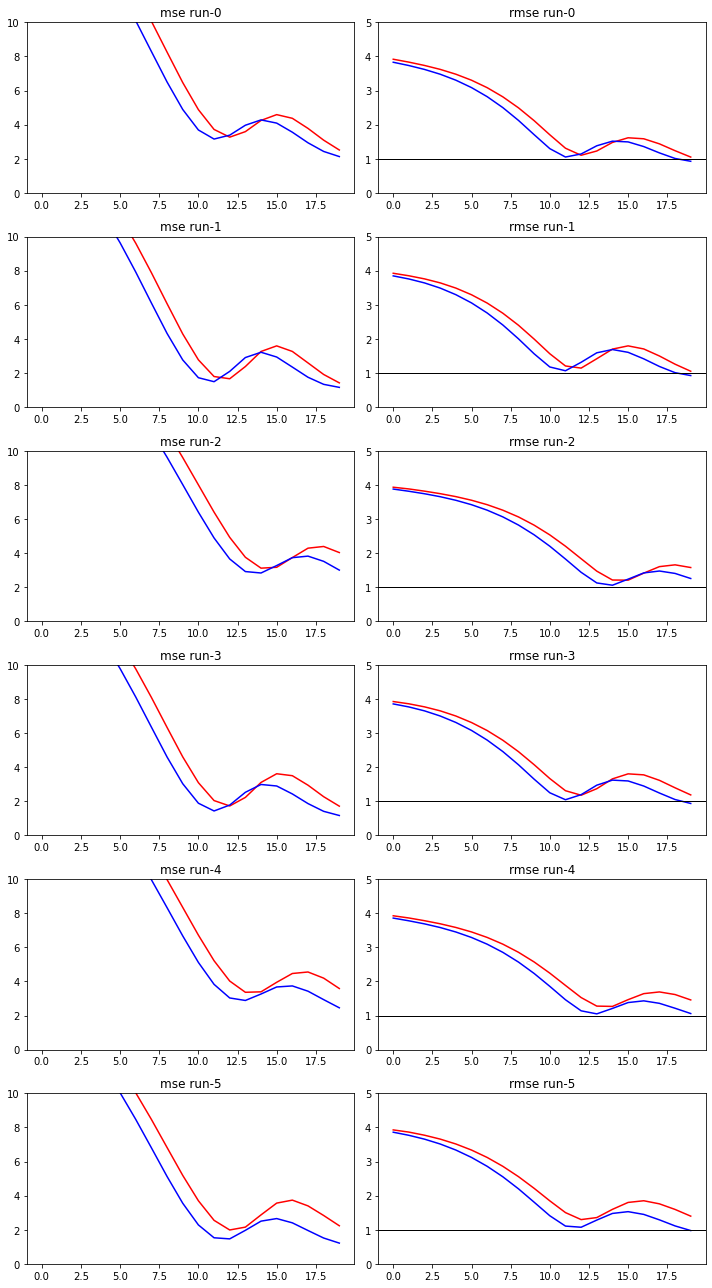

In [23]:
fig, axs = plt.subplots(ncols=2, nrows=len(run_history.keys()), figsize=(10, len(run_history.keys())*3))

for n, key in enumerate(run_history.keys()):
    axs[n,0].plot(run_history[key]['output'].history['loss'], color='r')
    axs[n,0].plot(run_history[key]['output'].history['val_loss'], color='b')
    
    axs[n,1].plot(run_history[key]['output'].history['root_mean_squared_error'], color='r')
    axs[n,1].plot(run_history[key]['output'].history['val_root_mean_squared_error'], color='b')
    
    title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys())
    
    axs[n,0].set_title("mse {}".format(key))
    axs[n,1].set_title("rmse {}".format(key))
    
    axs[n,0].set_ylim(0,10)
    axs[n,1].set_ylim(0,5)
    
    axs[n, 1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [24]:
run_history['run-0']

{'params': {'HP_NUM_UNITS': 64,
  'HP_DROPOUT': 0.3,
  'HP_LEARNING_RATE': 0.01,
  'HP_REGULARIZER': <tensorflow.python.keras.regularizers.L2 at 0x7f4f0e66e820>},
 'output': <tensorflow.python.keras.callbacks.History at 0x7f4efc7a5e80>}

In [26]:
run_history['run-0']['params']['HP_REGULARIZER'].l2

array(0.1, dtype=float32)

In [27]:
run_history['run-1']

{'params': {'HP_NUM_UNITS': 64,
  'HP_DROPOUT': 0.3,
  'HP_LEARNING_RATE': 0.01,
  'HP_REGULARIZER': 'l2'},
 'output': <tensorflow.python.keras.callbacks.History at 0x7f4efc4fe4f0>}

In [28]:
run_history['run-1']['params']['HP_REGULARIZER'].l2

AttributeError: 'str' object has no attribute 'l2'

In [29]:
import json
def export_history(run_history, batch_size, n_epochs, save_path):
    history_dict = run_history.copy()
    for key in history_dict:
        if history_dict[key]['params']['HP_REGULARIZER']=='l2':
            
            history_dict[key]['params']['HP_REGULARIZER'] = .01
        else:
            try:
                history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].l2.tolist()
            except:
                pass   
        if type(history_dict[key]['params']['HP_REGULARIZER']) == np.ndarray:
            history_dict[key]['params']['HP_REGULARIZER'] = history_dict[key]['params']['HP_REGULARIZER'].tolist()
        history_dict[key]['params']['batch_size'] = batch_size
        history_dict[key]['params']['n_epochs'] = n_epochs
        
        try:
            history_dict[key]['output'] = history_dict[key]['output'].history
        except:
            history_dict[key]['output'] = history_dict[key]['output']
      
    with open(save_path, 'w') as f:
        json.dump(history_dict, f)
    
    return history_dict

new_dict = export_history(run_history, len(X_train), 20, "./run_history/model4.json")